# Apply ExponentialSmoothing to the Training data

/opt/miniconda3/envs/rl_proj/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/var/folders/cc/238sxcy16y9bqkv952kk4gdh0000gn/T/ipykernel_8617/3322396482.py:65: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(


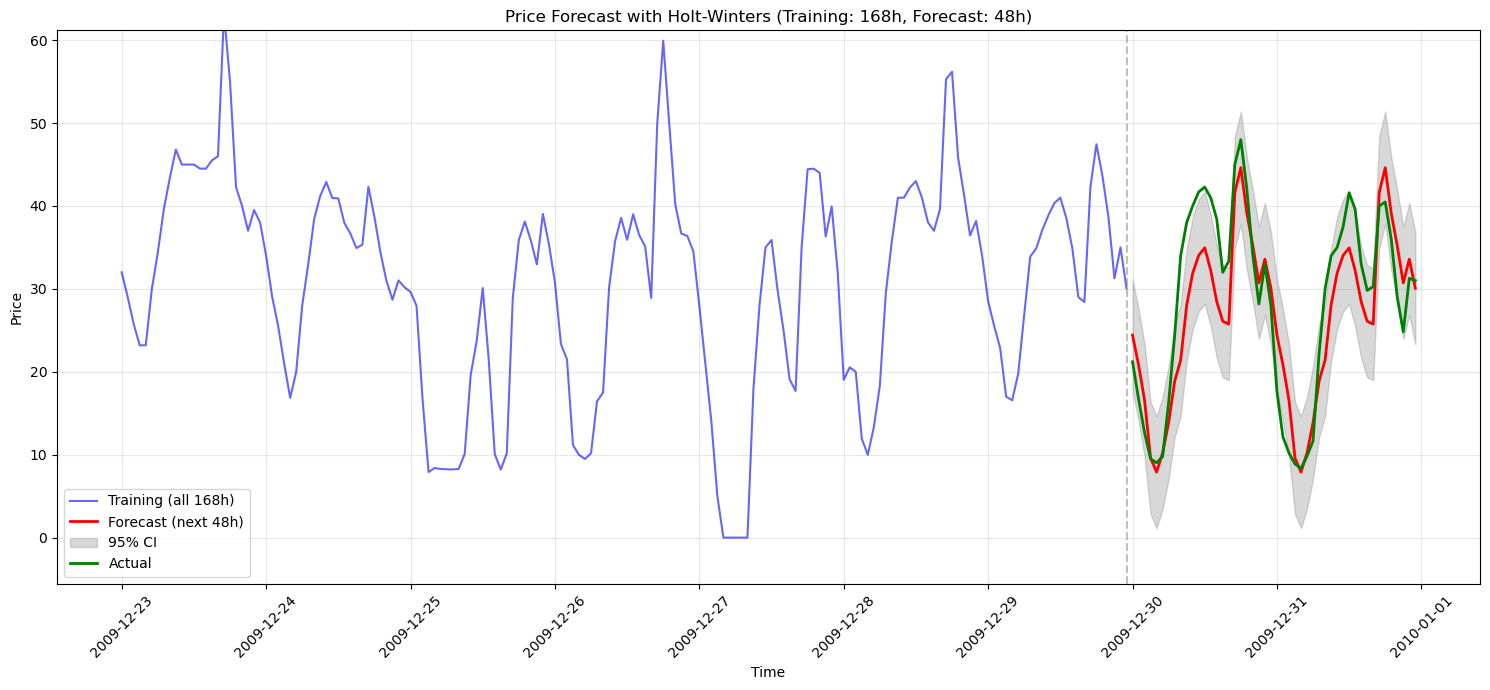


Forecast Comparison Results:
                     Forecast_Mean  Lower_95CI  Upper_95CI  Actual
2009-12-30 00:00:00      24.434163   17.674179   31.194147   21.21
2009-12-30 01:00:00      20.842012   14.082028   27.601997   16.73
2009-12-30 02:00:00      16.578453    9.818468   23.338437   12.66
2009-12-30 03:00:00       9.604896    2.844911   16.364880    9.50
2009-12-30 04:00:00       7.908496    1.148512   14.668480    9.04
2009-12-30 05:00:00      10.209254    3.449270   16.969239    9.78
2009-12-30 06:00:00      13.860030    7.100045   20.620014   16.30
2009-12-30 07:00:00      18.853673   12.093688   25.613657   24.36
2009-12-30 08:00:00      21.418741   14.658757   28.178725   34.00
2009-12-30 09:00:00      28.039495   21.279510   34.799479   38.01
2009-12-30 10:00:00      31.903094   25.143109   38.663078   40.01
2009-12-30 11:00:00      34.049537   27.289553   40.809522   41.70
2009-12-30 12:00:00      34.954545   28.194560   41.714529   42.28
2009-12-30 13:00:00      32.2166

In [1]:


##############################################
# 1. Configuration Parameters
##############################################
TRAINING_HOURS = 168  # Adjustable training window size
FORECAST_HOURS = 48   # Forecast horizon
SEASONAL_PERIODS = 24 # Seasonal period (24 hours)

##############################################
# 2. Imports
##############################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def prepare_data(train_file):
    """
    Prepare training data only
    """
    # Load training data
    df = pd.read_csv(train_file)
    df['PRICES'] = pd.to_datetime(df['PRICES'], format='%d/%b/%y')
    
    # Reshape data
    df_melted = df.melt(
        id_vars="PRICES",
        var_name="Hour",
        value_name="Price"
    )
    df_melted['Hour'] = df_melted['Hour'].str.replace('Hour ', '', regex=False).astype(int)
    
    # Create DateTime index
    df_melted['DateTime'] = df_melted.apply(
        lambda row: row['PRICES'] + pd.Timedelta(hours=row['Hour'] - 1),
        axis=1
    )
    
    # Sort and set index
    df_melted.sort_values(by='DateTime', inplace=True)
    ts_data = df_melted.set_index("DateTime")['Price'].sort_index()
    
    return ts_data

def train_and_forecast(training_data, test_data, training_hours=TRAINING_HOURS, 
                      forecast_hours=FORECAST_HOURS, seasonal_periods=SEASONAL_PERIODS):
    """
    Train model and generate forecasts
    """
    # Get training data
    train_window = training_data.iloc[-training_hours:].copy()
    
    # Train model
    model = ExponentialSmoothing(
        train_window,
        trend=None,
        seasonal='add',
        seasonal_periods=seasonal_periods
    ).fit()
    
    # Generate forecast
    forecast_mean = model.forecast(forecast_hours)
    
    # Set forecast index
    last_training_time = train_window.index[-1]
    forecast_index = pd.date_range(
        start=last_training_time + pd.Timedelta(hours=1),
        periods=forecast_hours,
        freq="H"
    )
    forecast_mean.index = forecast_index
    
    # Calculate confidence intervals
    residuals = train_window - model.fittedvalues
    resid_std = np.std(residuals.dropna())
    ci_multiplier = 1.96
    
    forecast_lower = forecast_mean - ci_multiplier * resid_std
    forecast_upper = forecast_mean + ci_multiplier * resid_std
    
    return train_window, forecast_mean, forecast_lower, forecast_upper

def plot_results(train_window, forecast_mean, forecast_lower, forecast_upper, test_data):
    """
    Plot results - showing all training data and 48-hour forecast
    """
    fig, ax = plt.subplots(figsize=(15,7))  # Increase figure size to accommodate more data
    
    # Calculate y-axis range (based on all displayed data)
    all_values = np.concatenate([
        train_window.values,
        forecast_mean.values,
        test_data.values[:FORECAST_HOURS]
    ])
    y_min = np.percentile(all_values, 1)
    y_max = np.percentile(all_values, 99)
    y_margin = (y_max - y_min) * 0.1
    
    # Create plot
    plt.plot(train_window.index, train_window.values, 
             label=f"Training (all {len(train_window)}h)", color='blue', alpha=0.6)
    plt.plot(forecast_mean.index, forecast_mean.values, 
             label=f"Forecast (next {FORECAST_HOURS}h)", color='red', linewidth=2)
    plt.fill_between(forecast_mean.index, forecast_lower, forecast_upper,
                     color='gray', alpha=0.3, label='95% CI')
    plt.plot(test_data.index[:FORECAST_HOURS], test_data.values[:FORECAST_HOURS], 
             label=f'Actual', color='green', linewidth=2)
    
    # Add vertical line to separate training data and forecast
    plt.axvline(x=train_window.index[-1], color='gray', linestyle='--', alpha=0.5)
    
    plt.ylim([y_min - y_margin, y_max + y_margin])
    plt.title(f"Price Forecast with Holt-Winters (Training: {len(train_window)}h, Forecast: {FORECAST_HOURS}h)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels to avoid overlap
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

def main(training_hours=TRAINING_HOURS):
    """ 
    Main function - using training data only
    """
    # Prepare training data
    ts_data = prepare_data("train.csv")
    
    # Split data into training and test sets
    train_data = ts_data[:-FORECAST_HOURS]  # All data except last 48 hours for training
    test_data = ts_data[-FORECAST_HOURS:]   # Last 48 hours for testing
    
    # Train and forecast
    train_window, forecast_mean, forecast_lower, forecast_upper = train_and_forecast(
        train_data, test_data, training_hours=training_hours
    )
    
    # Plot results
    fig = plot_results(train_window, forecast_mean, forecast_lower, forecast_upper, test_data)
    plt.show()
    
    # Print comparison results
    compare_df = pd.DataFrame({
        'Forecast_Mean': forecast_mean,
        'Lower_95CI': forecast_lower,
        'Upper_95CI': forecast_upper,
        'Actual': test_data
    })
    print("\nForecast Comparison Results:")
    print(compare_df)
    
    return compare_df

# Run the program
if __name__ == "__main__":
    # Training window size can be easily modified
    results = main(training_hours=TRAINING_HOURS)  # Example: using 72 hours of training data

# Testing the trained ETS model on the validate data

/opt/miniconda3/envs/rl_proj/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/var/folders/cc/238sxcy16y9bqkv952kk4gdh0000gn/T/ipykernel_8617/3322396482.py:65: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(


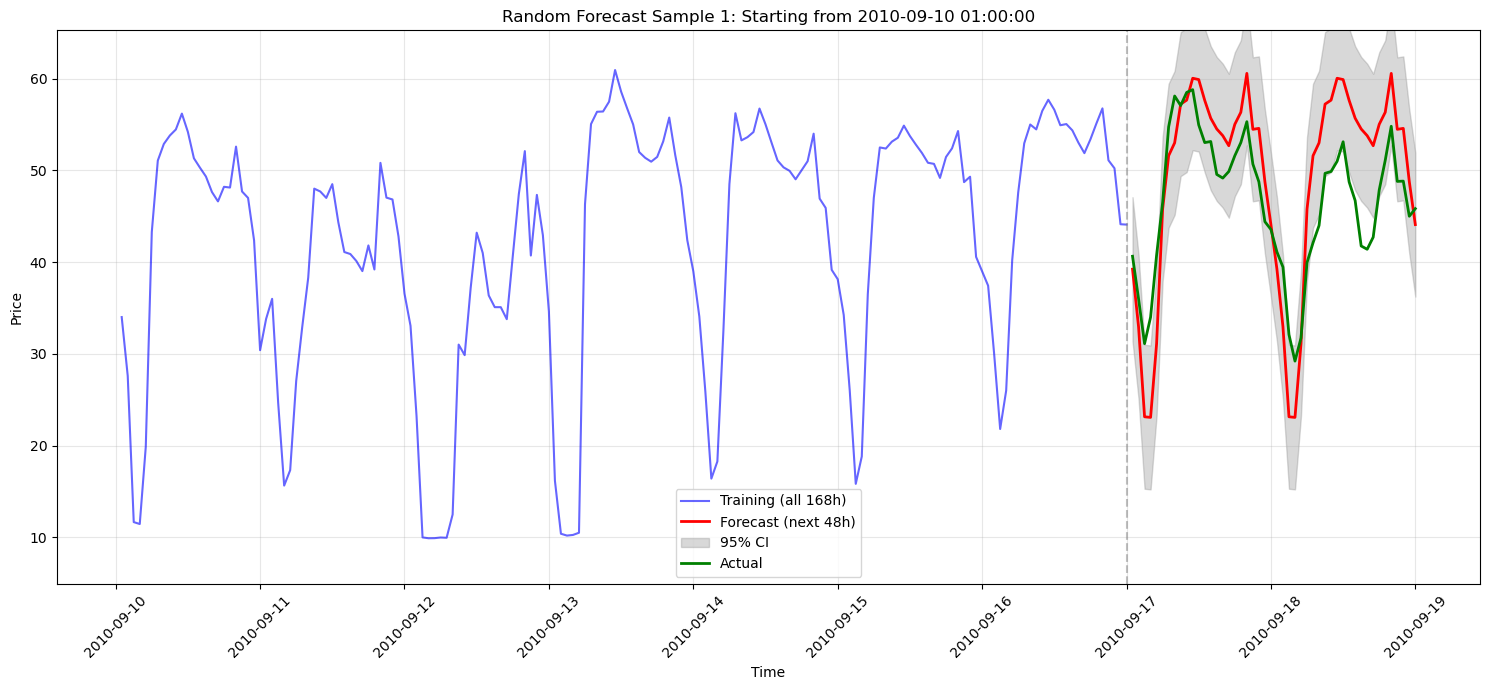

/opt/miniconda3/envs/rl_proj/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/var/folders/cc/238sxcy16y9bqkv952kk4gdh0000gn/T/ipykernel_8617/3322396482.py:65: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(



Sample 1 Forecast Errors:
MAPE: 12.44%
RMSE: 6.35


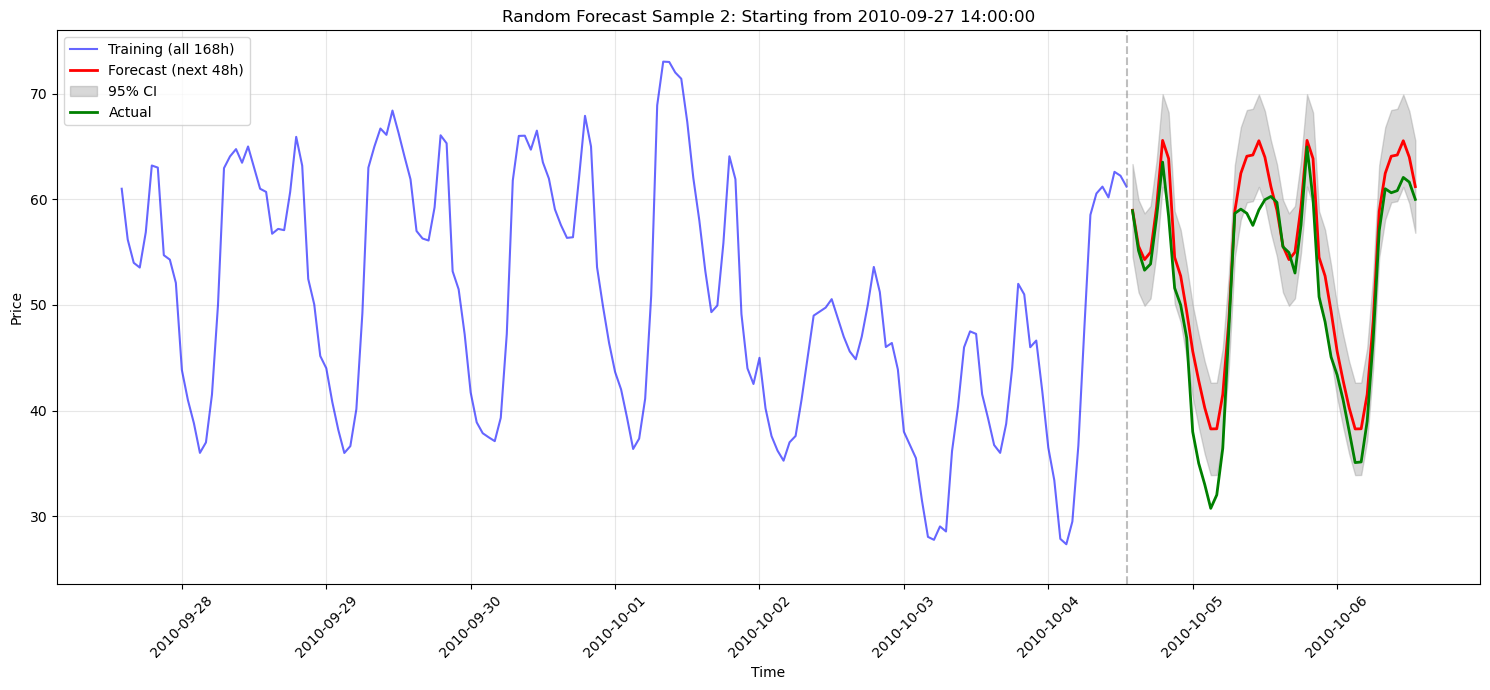


Sample 2 Forecast Errors:
MAPE: 6.68%
RMSE: 3.72


/opt/miniconda3/envs/rl_proj/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/var/folders/cc/238sxcy16y9bqkv952kk4gdh0000gn/T/ipykernel_8617/3322396482.py:65: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(


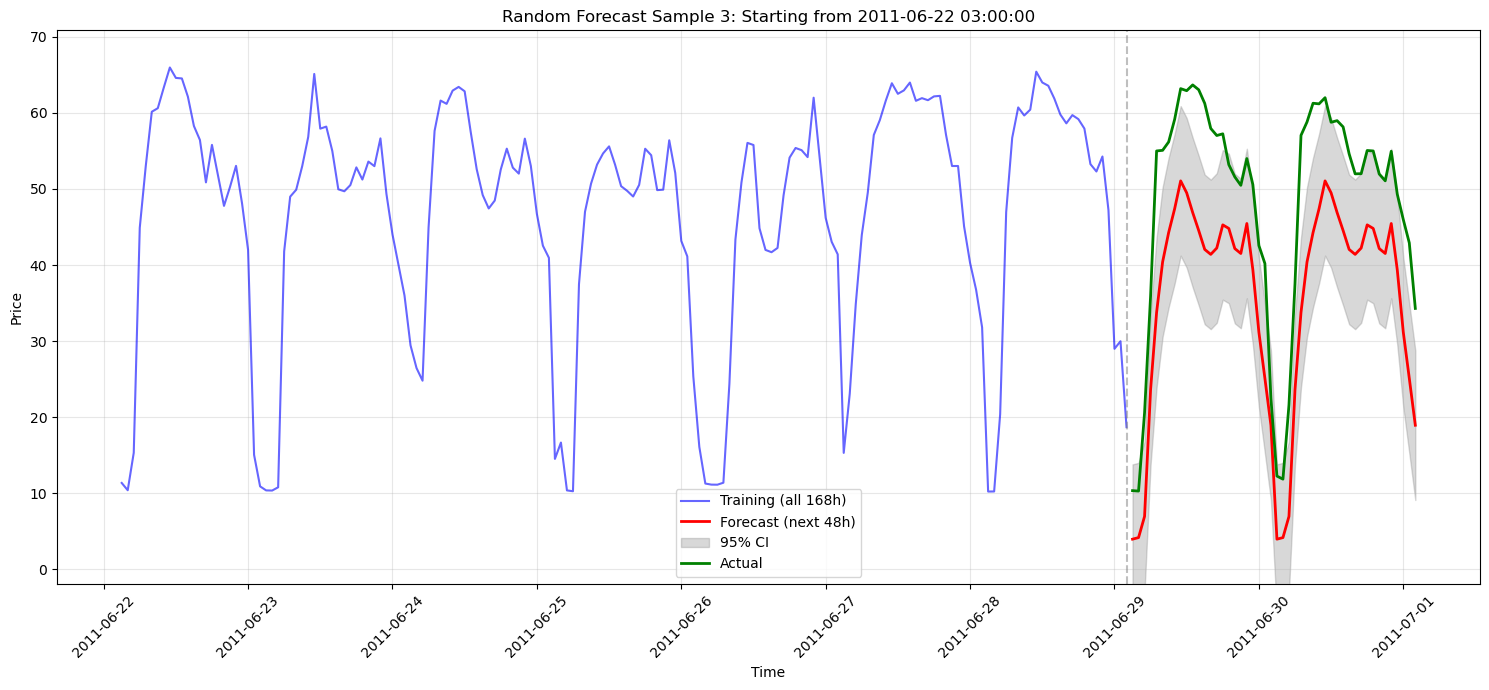


Sample 3 Forecast Errors:
MAPE: 29.78%
RMSE: 13.13

Overall Evaluation Results:
           Start Time   MAPE (%)       RMSE
0 2010-09-10 01:00:00  12.435754   6.347615
1 2010-09-27 14:00:00   6.675527   3.721336
2 2011-06-22 03:00:00  29.776923  13.125291


In [2]:
import random

def random_forecast_evaluation(ts_data, n_samples=5):
    """
    Randomly select time points from dataset for forecast evaluation
    
    Parameters:
    - ts_data: time series data
    - n_samples: number of random samples to evaluate
    """
    # Ensure we have enough data for training and testing
    available_start_points = len(ts_data) - (TRAINING_HOURS + FORECAST_HOURS)
    
    results = []
    
    for i in range(n_samples):
        # Random start point selection
        start_idx = random.randint(0, available_start_points)
        
        # Get training data
        train_end_idx = start_idx + TRAINING_HOURS
        test_end_idx = train_end_idx + FORECAST_HOURS
        
        train_data = ts_data.iloc[start_idx:train_end_idx]
        actual_data = ts_data.iloc[train_end_idx:test_end_idx]
        
        # Train and forecast
        train_window, forecast_mean, forecast_lower, forecast_upper = train_and_forecast(
            ts_data.iloc[:train_end_idx], 
            actual_data
        )
        
        # Plot results
        fig = plot_results(train_window, forecast_mean, forecast_lower, forecast_upper, actual_data)
        plt.title(f"Random Forecast Sample {i+1}: Starting from {train_window.index[0]}")
        plt.show()
        
        # Calculate forecast errors
        mape = np.mean(np.abs((actual_data - forecast_mean) / actual_data)) * 100
        rmse = np.sqrt(np.mean((actual_data - forecast_mean) ** 2))
        
        results.append({
            'Start Time': train_window.index[0],
            'MAPE (%)': mape,       
            'RMSE': rmse
        })
        
        print(f"\nSample {i+1} Forecast Errors:")
        print(f"MAPE: {mape:.2f}%")
        print(f"RMSE: {rmse:.2f}")
        
    return pd.DataFrame(results)

def plot_results(train_window, forecast_mean, forecast_lower, forecast_upper, test_data):
    """
    Plot results - showing all training data and 48-hour forecast
    """
    fig, ax = plt.subplots(figsize=(15,7))
    
    # Calculate y-axis range
    all_values = np.concatenate([
        train_window.values,
        forecast_mean.values,
        test_data.values[:FORECAST_HOURS]
    ])
    y_min = np.percentile(all_values, 1)
    y_max = np.percentile(all_values, 99)
    y_margin = (y_max - y_min) * 0.1
    
    # Plotting
    plt.plot(train_window.index, train_window.values, 
             label=f"Training (all {len(train_window)}h)", color='blue', alpha=0.6)
    plt.plot(forecast_mean.index, forecast_mean.values, 
             label=f"Forecast (next {FORECAST_HOURS}h)", color='red', linewidth=2)
    plt.fill_between(forecast_mean.index, forecast_lower, forecast_upper,
                     color='gray', alpha=0.3, label='95% CI')
    plt.plot(test_data.index[:FORECAST_HOURS], test_data.values[:FORECAST_HOURS], 
             label='Actual', color='green', linewidth=2)
    
    # Add vertical line to separate training data and forecast
    plt.axvline(x=train_window.index[-1], color='gray', linestyle='--', alpha=0.5)
    
    plt.ylim([y_min - y_margin, y_max + y_margin])
    plt.title(f"Price Forecast with Holt-Winters (Training: {len(train_window)}h, Forecast: {FORECAST_HOURS}h)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Adjust x-axis labels to avoid overlap
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

# Run random forecast evaluation
ts_data = prepare_data("validate.csv")
evaluation_results = random_forecast_evaluation(ts_data, n_samples=3)

print("\nOverall Evaluation Results:")
print(evaluation_results)